<a href="https://colab.research.google.com/github/JHPark-git/Repo/blob/main/nlp_nli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Baseline

In [ ]:
pip install transformers

     |████████████████████████████████| 3.8 MB 5.6 MB/s 
     |████████████████████████████████| 6.5 MB 25.1 MB/s 
     |████████████████████████████████| 67 kB 2.6 MB/s 
     |████████████████████████████████| 895 kB 43.8 MB/s 
     |████████████████████████████████| 596 kB 34.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import urllib.request
from sklearn import preprocessing
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/multinli.train.ko.tsv', filename = 'multinli.train.ko.tsv')
urllib.request.urlretrieve('https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/snli_1.0_train.ko.tsv', filename = 'snli_1.0_.train.ko.tsv')

urllib.request.urlretrieve('https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.dev.ko.tsv', filename = 'xnli.dev.ko.tsv')

urllib.request.urlretrieve('https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.test.ko.tsv', filename = 'xnli.test.ko.tsv')


('xnli.test.ko.tsv', <http.client.HTTPMessage at 0x7f566f13cd90>)

In [ ]:
train_snli = pd.read_csv('snli_1.0_.train.ko.tsv', sep='\t', quoting=3)
train_xnli= pd.read_csv('multinli.train.ko.tsv', sep='\t', quoting=3)
val_data = pd.read_csv('xnli.dev.ko.tsv', sep='\t', quoting=3)
test_data = pd.read_csv('xnli.test.ko.tsv', sep='\t', quoting=3)

In [ ]:
train_snli.head()

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [ ]:
train_xnli.head()

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral


In [ ]:
train_data = train_snli.append(train_xnli)
train_data = train_data.sample(frac=1)

In [ ]:
len(train_data),len(val_data),len(test_data)


(942854, 2490, 5010)

In [ ]:
def drop_na_duplicates(df):
  df = df.dropna()
  df = df.drop_duplicates() #중복 항 삭제
  df = df.reset_index(drop=True)
  return df

In [ ]:
train_data = drop_na_duplicates(train_data)
val_data = drop_na_duplicates(val_data)
test_data = drop_na_duplicates(test_data)

In [ ]:
len(train_data),len(val_data),len(test_data)


(941814, 2490, 5010)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')


Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [ ]:
max_seq_length = 128

In [ ]:
def convert_examples_to_features(sent_list1, sent_list2, max_seq_len, tokenizer):
  input_ids, attention_masks, token_type_ids = [],[],[]
  for sent1, sent2 in tqdm(zip(sent_list1, sent_list2), total=len(sent_list1), leave = False):
    encoding_result = tokenizer.encode_plus(sent1, sent2, max_length= max_seq_length, pad_to_max_length=True)
    input_ids.append(encoding_result['input_ids'])
    attention_masks.append(encoding_result['attention_mask'])
    token_type_ids.append(encoding_result['token_type_ids'])
  
  input_ids = np.array(input_ids, dtype=int)
  attention_masks = np.array(attention_masks, dtype=int)
  token_type_ids = np.array(token_type_ids, dtype=int)

  return (input_ids,attention_masks, token_type_ids)

In [ ]:
x_train = convert_examples_to_features(train_data['sentence1'], train_data['sentence2'], max_seq_length, tokenizer)

  0%|          | 0/941814 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
  1%|          | 8188/941814 [00:05<10:28, 1485.88it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So th

In [ ]:
input_id = x_train[0][0]
attention_mask = x_train[1][0]
token_type_id = x_train[2][0]

print(input_id, '\n', attention_mask, '\n', token_type_id)

[    2  3616  2116   850  2069  1142 13091  4034  1041  2205  2259   575
  2073  6093  2205  2118  3818  2307  3713  2125  4452  2119  4600  2062
    18     3   850  2145  3713  4452  2073  4245 19521   636  2031  2073
   831 13478  2205  2318  3877  4538    18     3     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0] 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
x_val = convert_examples_to_features(val_data['sentence1'], val_data['sentence2'], max_seq_length, tokenizer)
x_test = convert_examples_to_features(test_data['sentence1'], test_data['sentence2'], max_seq_length, tokenizer)


  0%|          | 0/2490 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_label = train_data['gold_label'].tolist()
val_label = val_data['gold_label'].tolist()
test_label = test_data['gold_label'].tolist()


In [ ]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_label)

y_train = label_encoder.transform(train_label)
y_val = label_encoder.transform(val_label)
y_test = label_encoder.transform(test_label)

(array([2, 0, 1, ..., 2, 0, 1]), array([0, 1, 2, ..., 2, 0, 1]))

In [ ]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('klue/bert-base', num_labels=3, from_pt=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience=2)

model.fit(
    x_train, y_train, epochs=2, batch_size=32, validation_data=(x_val, y_val), callbacks = [early_stopping]
)

Epoch 1/2
    3/29432 [..............................] - ETA: 372:25:54 - loss: 3.2473 - accuracy: 0.3438

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(x_test, y_test, batch_size=1024)

https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/18.%20Fine-tuning%20BERT%20(Cls%2C%20NER%2C%20NLI)/18-5.%20kor_bert_kornli_model_from_transformers_tpu.ipynb

# koBERT Baseline


**nlp.data.BERTSentenceTransform(vocab, max_seq_length, pad, pair)**

토큰 인덱스, 유효길이, segment 인덱스 반환

In [ ]:
class BERTDataset(Dataset):
  def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
               pad, pair, mode = 'train'):
    self.mode = mode
    transform = nlp.data.BERTSentenceTransform(bert_tokenizer,
                                                max_seq_length = max_len,
                                                pad = pad,
                                                pair = pair)
    if self.mode = 'train':
      self.sentences = [transform([i[sent_idx]]) for i in dataset]
      self.labels = [np.int32(i[label_idx]) for i in dataset]

    else:
      self.sentences = [transform(i[sent_idx]) for i in dataset]
    
  def __getitem__(self,i):
    if self.mode == 'train':
      return (self.sentence[i] + (self.labels[i], ))
    else:
      return self.sentences[i]
  def __len__(self):
    return (len(self.sentences))  

In [ ]:
class BERTClassifier(nn.Module):
  def__init__(self, bert, hidden_size = 768, num_classes=3, dr_rate=None, params=None):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dr_rate = dr_rate

    self.classifier = nn.Linear(hidden_size, num_classes)
    if dr_rate:
      self.dropout = nn.Dropout(p=dr_rate)

  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i,v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()
    
  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.gen_attention_mask(token_ids, valid_length)

    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
    if self.dr_rate:
      out = self.dropout(pooler)
    return self.classifier(out)


weight decay란 model의 overfitting을 방지하기 위해서 cost function에 가중치를 더해 학습에 따른 weight의 증가폭을 감축하는 것.

grouped parameters로 weight만 lambda 0.01로 decay하고, bias와 LayerNorm.weight은 decay에서 제외.

In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_ground_parameters = [
  {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay':0.01},
  {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def calc_accuracy(x,y):
  max_vals, max_indices = torch.max(x,1)
  train_acc = (max_indices==y).sum().data.cpu().numpy()/max_indices.szie()[0]
  return train_acc

**torch.nn.utils.clip_grad_norm_**

그래디언트 클리핑: 학습에서 출력의 길이에 따라 기울기의 크기가 달라짐. 이에 norm의 크기를 max_grad_norm(하이퍼 파라미터)로 제한하는 방법.

In [ ]:
for e in range(num_epochs):
  train_acc= 0.0
  valid_acc= 0.0
  model.train()
  for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    optimizer.zero_grad()
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    loss = loss_fn(out, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.paraeters(), max_grad_norm)
    optimizer.step()
    train_acc += calc_accuracy(out, label)
  
  print('epoch {} train_acc {}'.format(e+1, train_acc/(batch_id+1)))
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)
      valid_length= valid_length
      label = label.long().to(device)
      out = model(token_ids, valid_length, segment_ids)
      valid_acc += calc_accuracy(out, label)
  print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))


In [ ]:
result = []
model.eval()
with torch.no_grad():
  for batch_id, (token_ids, valid_length, segment_ids) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        result.append(model(token_ids, valid_length, segment_ids))

In [ ]:
result_ = []
for i in result:
  for j in i:
    result_.append(int(torch.argmax(j)))

out = [list(label_dict.keys())[_] for _ in result_]]
submission['label'] = out
submission.to_csv('sample_submission.csv', index = False)

# Roberta Large/trainer+stkold+앙상블

In [ ]:
!pip install datasets transformers

     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 3.8 MB 49.6 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 212 kB 51.9 MB/s 
     |████████████████████████████████| 1.1 MB 42.0 MB/s 
     |████████████████████████████████| 134 kB 33.5 MB/s 
     |████████████████████████████████| 127 kB 51.6 MB/s 
     |████████████████████████████████| 596 kB 47.0 MB/s 
     |████████████████████████████████| 895 kB 50.0 MB/s 
     |████████████████████████████████| 6.5 MB 34.5 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 52.5 MB/s 
     |████████████████████████████████| 271 kB 54.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [ ]:
from datasets import concatenate_datasets, load_dataset, load_metric
import zipfile
import pandas as pd
import random
import numpy as np
import os
import torch
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import StratifiedKFold
from datasets import Dataset
from scipy.special import softmax

In [ ]:
path_to_zip_file = '/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류.zip'
directory_to_extract_to = '/content'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
#test = pd.read_csv('/content/open/test_data.csv')
test = load_dataset('csv',data_files={'test':'/content/open/test_data.csv'})
submission = pd.read_csv('/content/open/sample_submission.csv')

Using custom data configuration default-38dfa5b7ac57162b


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-38dfa5b7ac57162b/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
test

DatasetDict({
    test: Dataset({
        features: ['index', 'premise', 'hypothesis', 'label'],
        num_rows: 1666
    })
})

In [ ]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # for faster training, but not deterministic

In [ ]:
set_seeds(seed=2022)  
model_checkpoint = "klue/roberta-large"
batch_size = 32
task = "nli"

In [ ]:
set_seeds(seed=20)   
model_checkpoint = "klue/roberta-large"
batch_size = 32
task = "nli"

In [ ]:
set_seeds(seed=25)   
model_checkpoint = "klue/roberta-large"
batch_size = 32
task = "nli"

In [ ]:
set_seeds(seed=2)   
model_checkpoint = "klue/roberta-large"
batch_size = 32
task = "nli"

In [ ]:
datasets = load_dataset('klue', task)

Generating train split:   0%|          | 0/24998 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/nli/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 24998
    })
    validation: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 3000
    })
})

In [ ]:
def show_random_element(dataset, num_examples=10):
  assert num_examples >= len(datasets), 'Cannot pick more than their length'

  picks = []

  for _ in range(num_examples):
    pick = random.randint(0, len(dataset)-1)

    while pick in picks:
      pick = random.randint(0, len(dataset)-1)
    picks.append(pick)

  df = pd.DataFrame(dataset[picks])
  
  display(df)
  

In [ ]:
show_random_element(datasets['train'])

,guid,source,premise,hypothesis,label
0,klue-nli-v1_train_01853,wikipedia,경의선은 서울특별시 용산구의 서울역과 경기도 파주시의 도라산역을 잇는 한국철도공사의...,경의선은 청량리역과 춘천역을 잇는 노선이다.,2
1,klue-nli-v1_train_03001,wikipedia,그녀는 유방암 진단을 받아 투병하고 있다.,그녀는 유방암으로 투병 중이다.,0
2,klue-nli-v1_train_02781,NSMC,굿굿 야한장면 있지만 생로랑 강추해요,야한장면이 나오지만 19세는 아니에요.,1
3,klue-nli-v1_train_11831,policy,"식약처는 외식업체의 의무를 강화하기 위해 종사자 마스크 쓰기, 소독 장치 구비 등 ...",방역 상 중요한 사항은 종사자 마스크 쓰기 뿐이다.,2
4,klue-nli-v1_train_05540,NSMC,다큐라는데 연출된듯한 에피소드에 사실성두 없구 편집두 이상하구 그냥 종교 다큐,사실성 있는 에피소드이고 편집이 훌륭하다.,2
5,klue-nli-v1_train_24116,wikitree,행사에 참여한 군인 수십명이 도망가고 경호원들은 방탄복으로 대통령을 보호했다.,행사에 참여한 군인 모두 남아 대통령을 보호했다.,2
6,klue-nli-v1_train_21945,wikipedia,코지마의 생일날인 12월 25일 크리스마스는 일요일이었다.,코지마의 생일은 수요일이였다.,2
7,klue-nli-v1_train_10097,wikinews,"산사태나 강의 범람으로 철로가 유실되면서 경부선, 경전선, 동해남부선 열차의 운행이...",산사태나 강의 범람으로 철로가 유실되었다.,0
8,klue-nli-v1_train_08243,airbnb,무엇보다도 숙소의 위치가 가장 좋습니다.,무엇보다도 숙소의 위치가 제일 싫습니다.,2
9,klue-nli-v1_train_19855,wikitree,중국농업대학교는 2002년부터 광주전남연구원과 업무협약을 맺고 농업 관련 학술교류를...,중국농업대학교는 광주전남연구원 뿐 아니라 다른 여러 곳과 업무협약을 맺었다.,1


In [ ]:
sentence1_key, sentence2_key = ('premise','hypothesis')

def preprocess_function(examples):
  return tokenizer(
      examples[sentence1_key],
      examples[sentence2_key],
      truncation=True,
      #return_token_type_ids=False,
  )

In [ ]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions , axis=1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
metric = load_metric('glue','qnli')

In [ ]:
metric_name = 'accuracy'
label_dict = {'entailment':0, 'neutral':1, 'contradiction':2}

args = TrainingArguments(
    'test_nli',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay=0.01,
    load_best_model_at_end = True,
    metric_for_best_model = metric_name,
)

In [ ]:
metric_name = 'accuracy'
label_dict = {'entailment':0, 'neutral':1, 'contradiction':2}

args = TrainingArguments(
    'test_nli',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 8,
    weight_decay=0.01,
    load_best_model_at_end = True,
    metric_for_best_model = metric_name,
)

In [ ]:
metric_name = 'accuracy'
label_dict = {'entailment':0, 'neutral':1, 'contradiction':2}

args = TrainingArguments(
    'test_nli',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 3,
    weight_decay=0.01,
    load_best_model_at_end = True,
    metric_for_best_model = metric_name,
)

In [ ]:
encoded_datasets['train']

Dataset({
    features: ['guid', 'source', 'premise', 'hypothesis', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 24998
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
encoded_datasets = datasets.map(preprocess_function, batched=True)
encoded_test = test['test'].remove_columns('label').map(preprocess_function, batched=True, remove_columns = ['premise',])

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=2022, shuffle=True)
tot_train = concatenate_datasets([encoded_datasets['train'], encoded_datasets['validation']])
tot_train_pd = pd.DataFrame(tot_train)

In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=20, shuffle=True)
tot_train = concatenate_datasets([encoded_datasets['train'], encoded_datasets['validation']])
tot_train_pd = pd.DataFrame(tot_train)

In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=25, shuffle=True)
tot_train = concatenate_datasets([encoded_datasets['train'], encoded_datasets['validation']])
tot_train_pd = pd.DataFrame(tot_train)

In [ ]:
skf = StratifiedKFold(n_splits=15, random_state=2, shuffle=True)
tot_train = concatenate_datasets([encoded_datasets['train'], encoded_datasets['validation']])
tot_train_pd = pd.DataFrame(tot_train)

In [ ]:
for n_fold, (_,v_idx) in enumerate(skf.split(tot_train_pd, tot_train_pd['label'])):
  tot_train_pd.loc[v_idx, 'fold'] = n_fold

In [ ]:
for i in range(0,10):
  model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
  trainer = Trainer(
      model,
      args,
      train_dataset = Dataset.from_pandas(tot_train_pd[tot_train_pd['fold']!=i]),
      eval_dataset = Dataset.from_pandas(tot_train_pd[tot_train_pd['fold']==i]),
      tokenizer = tokenizer,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  outputs = trainer.predict(encoded_test)
  prob = softmax(outputs[0],axis=1)
  np.save('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code1/str(i),prob')

In [ ]:
for i in range(0,10):
  model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
  trainer = Trainer(
      model,
      args,
      train_dataset = Dataset.from_pandas(tot_train_pd[tot_train_pd['fold']!=i]),
      eval_dataset = Dataset.from_pandas(tot_train_pd[tot_train_pd['fold']==i]),
      tokenizer = tokenizer,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  outputs = trainer.predict(encoded_test)
  prob = softmax(outputs[0],axis=1)
  np.save('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code2/str(i),prob')

In [ ]:
for i in range(0,10):
  model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
  trainer = Trainer(
      model,
      args,
      train_dataset = Dataset.from_pandas(tot_train_pd[tot_train_pd['fold']!=i]),
      eval_dataset = Dataset.from_pandas(tot_train_pd[tot_train_pd['fold']==i]),
      tokenizer = tokenizer,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  outputs = trainer.predict(encoded_test)
  prob = softmax(outputs[0],axis=1)
  np.save('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code3/str(i),prob')

In [ ]:
for i in range(0,15):
  model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
  trainer = Trainer(
      model,
      args,
      train_dataset = Dataset.from_pandas(tot_train_pd[tot_train_pd['fold']!=i]),
      eval_dataset = Dataset.from_pandas(tot_train_pd[tot_train_pd['fold']==i]),
      tokenizer = tokenizer,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  outputs = trainer.predict(encoded_test)
  prob = softmax(outputs[0],axis=1)
  np.save('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code4/str(i),prob')

In [ ]:
ch1 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code1/0.npy')
ch2 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code1/1.npy')
ch3 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code1/2.npy')
#...
ch10 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code1/9.npy')

ch11 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code2/0.npy')
#...
ch20 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code2/1.npy')

ch21 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code3/0.npy')
#...
ch30 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code3/9.npy')

ch31 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code4/0.npy')
#...
ch45 = np.load('/content/drive/MyDrive/Colab Notebooks/dataset/한국어문장관계분류/code4/14.npy')

In [ ]:
ch10fold1 = (ch1+ch2+ch3+ch4+ch5+ch6+ch7+ch8+ch9+ch10)/10
ch10fold2 = (ch11+ch12+ch13+ch14+ch15+ch16+ch17+ch18+ch19+ch20)/10
ch10fold3 = (ch21+ch22+ch23+ch24+ch25+ch26+ch27+ch28+ch29+ch30)/10
ch15fold1 = (ch31+ch32+ch33+ch34+ch35+ch36+ch37+ch38+ch39+ch40+ch41+ch42+ch43+ch44+ch45)/15


In [ ]:
ch = 0.25*ch10fold1 + 0.4*ch10fold2 + 0.15*ch10fold3 + 0.2*ch15fold1

submission['label'] = pd.Series(np.argmax(ch, axis=1)).apply(lambda x: {v,k for k,v in map_dict.items()}[x])
submission

# Roberta Large/stkfold

In [2]:
!tar -xzvf '/content/klue-nli-v1.1.tar.gz'

klue-nli-v1.1/
klue-nli-v1.1/klue-nli-v1.1_dev.json
klue-nli-v1.1/klue-nli-v1.1_dev_sample_10.json
klue-nli-v1.1/klue-nli-v1.1_train.json


In [3]:
import pandas as pd
import json

with open('/content/klue-nli-v1.1/klue-nli-v1.1_train.json','r') as f:
  train_data = json.load(f)
with open('/content/klue-nli-v1.1/klue-nli-v1.1_dev.json', 'r') as f:
  dev_data = json.load(f)
klue_nli_train_df = pd.DataFrame(train_data)
klue_nli_dev_df = pd.DataFrame(dev_data)
klue_nli_df = pd.concat([klue_nli_train_df, klue_nli_dev_df])

In [10]:
print(len(klue_nli_train_df), len(klue_nli_dev_df))

24998 3000


In [5]:
klue_nli_df['genre'].unique()

array(['NSMC', 'airbnb', 'wikipedia', 'wikinews', 'policy', 'wikitree',
       nan], dtype=object)

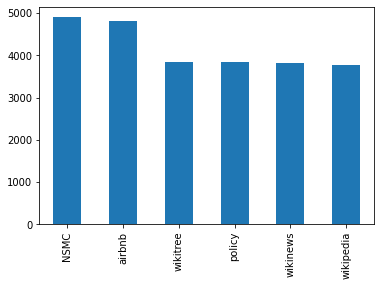

In [11]:
klue_nli_df['genre'].value_counts().plot(kind='bar')

In [ ]:
df_sentiment = klue_nli_df[(klue_nli_df['genre']=='NSMC')|(klue_nli_df['genre']=='airbnb')]
df_informative = klue_nli_df[(klue_nli_df['genre']!='NSMC')&(klue_nli_df['genre']!='airbnb')]


**np.select(condlist, choicelist)**

condlist에 choicelist를 적용해 출력함.


In [ ]:
list1 = [(train['label']=='entailment'),(train['label']=='contradiction'),(train['label']=='neutral')]
choicelist1 = [0,2,1]
train['label'] = np.select(list1, choicelist1)

train= train[['premise'],['hypothesis'],['label']]
test = test[['premise'],['hypothesis']]


In [ ]:
def calc_accuracy(x,y): # out, label
  max_vals, max_indices = torch.max(x,1)
